<a href="https://colab.research.google.com/github/VyomPandya/Summer-Internship-Sem-7/blob/main/Week_2_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation Using RFM Analysis

This notebook implements customer segmentation using RFM (Recency, Frequency, Monetary) analysis with multiple clustering algorithms on e-commerce transaction data.

## Project Overview

**Objective:** Segment customers based on their purchasing behavior and develop targeted marketing strategies for each segment.

**Data Source:** E-commerce transaction data stored in `master_dataset.csv`.

## Implementation Steps

### 1. Data Preparation
- Loading and cleaning transaction data
- Converting timestamps to proper datetime format
- Removing incomplete records
- Establishing a reference point ("today") for recency calculations

### 2. RFM Feature Extraction
The analysis uses the three standard RFM metrics:
- **Recency:** Days since customer's last purchase
- **Frequency:** Number of unique orders by the customer
- **Monetary:** Total amount spent by the customer

### 3. Data Preprocessing
- Filtering out zero-value customers
- Standardizing features using `StandardScaler`
- Preparing data for clustering algorithms

### 4. Clustering Approaches
Two different clustering methods are implemented for comparison:

1. **MiniBatchKMeans:**
   - Memory-efficient version of K-Means
   - Configured for large datasets with batch processing
   - Fast convergence with 4 predefined clusters

2. **HDBSCAN (Hierarchical Density-Based Spatial Clustering):**
   - Density-based clustering that can find clusters of varying shapes
   - Identifies outliers as noise points
   - Configurable minimum cluster size

### 5. Dimensionality Reduction for Visualization
Two techniques are used to visualize high-dimensional data:

1. **Principal Component Analysis (PCA):**
   - Linear dimensionality reduction
   - Preserves global structure and variance
   - Faster computation for large datasets

2. **t-SNE (t-Distributed Stochastic Neighbor Embedding):**
   - Non-linear dimensionality reduction
   - Better at preserving local relationships
   - Reveals cluster structures not visible in PCA

### 6. Segment Analysis and Strategy Assignment
- Computing cluster centroids in RFM space
- Analyzing cluster characteristics
- Assigning targeted marketing strategies based on segment behavior:
  - **VIP:** Reward and upsell opportunities
  - **At-Risk:** Win-back campaigns
  - **Low-Value:** Promotional offers
  - **Mid-Value:** Loyalty programs

### 7. Visualization of Segments
- Scatter plots of clusters using PCA coordinates
- Alternative visualization using t-SNE
- Bar chart showing distribution of customers across marketing strategies

## Business Applications

This customer segmentation system can be used to:
1. Develop personalized marketing campaigns for different customer segments
2. Allocate marketing resources more efficiently
3. Identify high-value customers for retention efforts
4. Recognize at-risk customers for proactive intervention
5. Understand customer portfolio composition and value distribution

## Results and Insights

The clustering approach reveals distinct customer segments based on their purchasing behavior, allowing for:
- Identification of high-value customer segments
- Recognition of customers with potential for growth
- Early detection of customers at risk of churning
- Optimization of marketing spend across segments

## Future Improvements

Potential enhancements to consider:
- Including additional behavioral features (e.g., product categories, session data)
- Time-based segmentation to track customer movement between segments
- A/B testing of marketing strategies for different segments
- Predictive modeling to anticipate segment transitions
- Customer lifetime value projections by segment

In [ ]:
#── Install libraries
!pip install -q pandas numpy matplotlib seaborn scikit-learn hdbscan openpyxl

#── Prevent MKL/OpenMP memory leaks
import os
os.environ["OMP_NUM_THREADS"] = "1"

#── Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

#── Dimensionality reduction & clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
# Add this to your imports block
from sklearn.manifold import TSNE
import hdbscan

# Optionally for out-of-core:
# from dask_ml.cluster import KMeans as DaskKMeans
df = pd.read_csv('master_dataset.csv')  # Replace with actual file path

# Convert timestamps
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Drop incomplete rows
df = df.dropna(subset=['order_delivered_customer_date','price'])

# Reference “today” for Recency
snapshot = df['order_delivered_customer_date'].max() + timedelta(days=1)

# Named aggregation for RFM per customer
rfm = (
    df.groupby('customer_unique_id')
      .agg(
         Recency=('order_delivered_customer_date',
                  lambda x: (snapshot - x.max()).days),
         Frequency=('order_id','nunique'),
         Monetary=('price','sum')
      )
      .reset_index()
)

# Filter any zero‐value customers
rfm = rfm[(rfm.Frequency>0) & (rfm.Monetary>0)]

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

In [ ]:
mbk = MiniBatchKMeans(
    n_clusters=4,
    batch_size=10000,
    max_no_improvement=10,
    random_state=42
)
rfm['KMeans_Cluster'] = mbk.fit_predict(X)


In [ ]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size=50,
    gen_min_span_tree=True
)
rfm['DBSCAN_Cluster'] = hdb.fit_predict(X)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


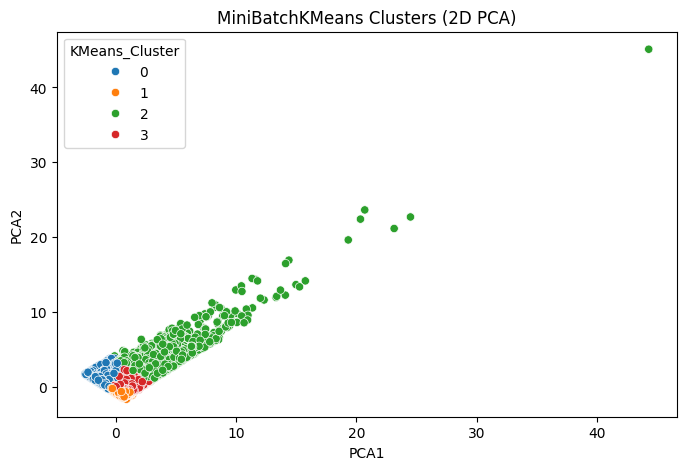

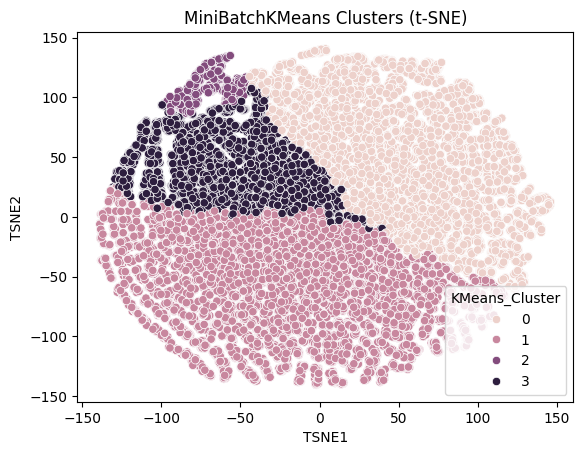

In [ ]:
# 2D PCA for plotting
pca2 = PCA(n_components=2, random_state=42)
vis_2d = pca2.fit_transform(X)
rfm['PCA1'], rfm['PCA2'] = vis_2d[:,0], vis_2d[:,1]

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=rfm, x='PCA1', y='PCA2',
    hue='KMeans_Cluster', palette='tab10',
    legend='full'
)
plt.title('MiniBatchKMeans Clusters (2D PCA)')
plt.show()

# Optional: t-SNE (may be slower on very large data)
tsne = TSNE(n_components=2, perplexity=30, n_jobs=2, random_state=42)
tsne_2d = tsne.fit_transform(X)
rfm['TSNE1'], rfm['TSNE2'] = tsne_2d[:,0], tsne_2d[:,1]
sns.scatterplot(data=rfm, x='TSNE1', y='TSNE2', hue='KMeans_Cluster')
plt.title('MiniBatchKMeans Clusters (t-SNE)')
plt.show()


In [ ]:
# Calculate cluster centroids in RFM space
cluster_summary = rfm.groupby('KMeans_Cluster')[['Recency','Frequency','Monetary']].mean()

def recommend_strategy(row):
    c = row['KMeans_Cluster']
    rec, freq, mon = cluster_summary.loc[c]
    if freq > cluster_summary['Frequency'].quantile(0.75):
        return 'VIP: Reward & Upsell'
    if rec > cluster_summary['Recency'].quantile(0.75):
        return 'At-Risk: Win-back Campaign'
    if mon < cluster_summary['Monetary'].quantile(0.25):
        return 'Low-Value: Promotional Offers'
    return 'Mid-Value: Loyalty Programs'

rfm['Strategy'] = rfm.apply(recommend_strategy, axis=1)
rfm[['customer_unique_id','KMeans_Cluster','Strategy']].head(10)


,customer_unique_id,KMeans_Cluster,Strategy
0,0000366f3b9a7992bf8c76cfdf3221e2,1,Low-Value: Promotional Offers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,Low-Value: Promotional Offers
2,0000f46a3911fa3c0805444483337064,0,At-Risk: Win-back Campaign
3,0000f6ccb0745a6a4b88665a16c9f078,0,At-Risk: Win-back Campaign
4,0004aac84e0df4da2b147fca70cf8255,3,Mid-Value: Loyalty Programs
5,0004bd2a26a76fe21f786e4fbd80607f,3,Mid-Value: Loyalty Programs
6,00050ab1314c0e55a6ca13cf7181fecf,1,Low-Value: Promotional Offers
7,00053a61a98854899e70ed204dd4bafe,3,Mid-Value: Loyalty Programs
8,0005e1862207bf6ccc02e4228effd9a0,0,At-Risk: Win-back Campaign
9,0005ef4cd20d2893f0d9fbd94d3c0d97,1,Low-Value: Promotional Offers


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['KMeans_Cluster'].plot(kind='hist', bins=20, title='KMeans_Cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Strategy').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='KMeans_Cluster', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['KMeans_Cluster']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Strategy')):
  _plot_series(series, series_name, i)
  fig.legend(title='Strategy', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('KMeans_Cluster')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Strategy')):
  _plot_series(series, series_name, i)
  fig.legend(title='Strategy', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['KMeans_Cluster'].plot(kind='line', figsize=(8, 4), title='KMeans_Cluster')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['Strategy'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='Strategy', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Strategy'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='KMeans_Cluster', y='Strategy', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

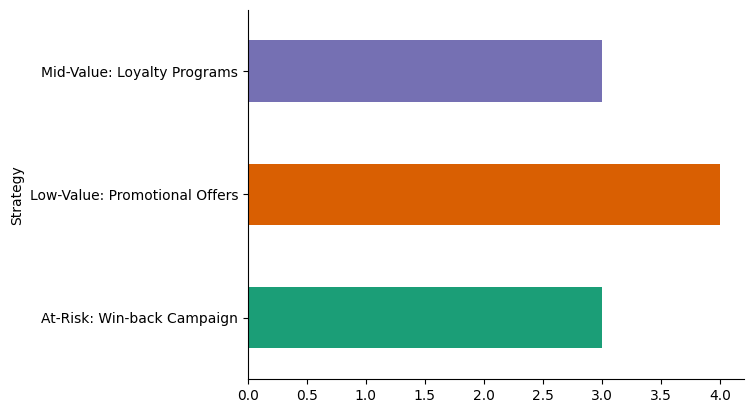

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Strategy').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)